#  Finding Well-Performing Pairs

In this notebook, our objective is to identify high-performing stock pairs that could be suitable for pairs trading. We use the best-performing machine learning model (selected in the `model_maker` notebook) to evaluate and rank candidate pairs.

Both the training and testing datasets are divided into a **formation period** (used to compute features) and a **trading period** (used to assess performance). The target variable is binary:
- **1** if a pair had **6 or more zero crossings** during the trading period  
- **0** otherwise.

To evaluate model performance, we apply a **custom scoring function** that selects the **10 pairs with the highest predicted probability** of being class 1 and calculates the fraction that actually are. This helps us focus on the most promising trading opportunities.


## Data processing

We first load our price data and calculate the **cumulative returns**.

Cumulative returns measure the total percentage change in an investment's value over time, assuming all gains are reinvested.

In this project, we compute **log cumulative returns**, which are useful for comparing price movements across different stocks and for simplifying compounding calculations.

The log cumulative return at time $t$ is calculated as:

$$
\text{Cumulative Return}(t) = \sum_{i=1}^{t} \log\left(\frac{P_i}{P_{i-1}}\right) + 1
$$

Where:
- $P_i$ is the stock price at time $i$
- $\log\left(\frac{P_i}{P_{i-1}}\right)$ is the daily log return

We add 1 so that all series are **normalized to start at 1.0**, making it easier to compare performance across assets with different price levels.

In [80]:
from pairmaker import select_pairs, calculate_metrics, plot_pairs, parse_pair
import numpy as np
import pandas as pd
import yfinance as yf

In [79]:
# load initial data
prices_train = pd.read_csv('vbr13_16.csv', index_col='Date')
prices_test = pd.read_csv('vbr16_19.csv', index_col='Date')

# calculate cumulative returns
cumret_train = np.log(prices_train).diff().cumsum()+1
cumret_train.dropna(how='all', inplace=True)
cumret_train.dropna(axis=1, inplace=True)
cumret_test = np.log(prices_test).diff().cumsum()+1
cumret_test.dropna(how='all', inplace=True)

# divide by first row so that all prices start at 1
cumret_train = cumret_train / cumret_train.iloc[0]
cumret_test = cumret_test / cumret_test.iloc[0]

train_form = cumret_train.loc['2013-01-01':'2015-12-31'] # formation period (train data)
train_trade = cumret_train.loc['2016-01-01':] # trading period (train data)
test_form = cumret_test.loc['2016-07-01':'2019-06-31'] # formation period (test data)
test_trade = cumret_test.loc['2019-07-01':] # trading period (test data)

/Users/zakiahmed/Desktop/Pythonstuff/myenv/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


We preload the following data as the functions `select_pairs` and `calculate_metrics` are very inefficient.

In [69]:
# preloaded data
pairs_train = pd.read_csv("pairs13_16.csv")
pairs_test = pd.read_csv("pairs16_19.csv")
metrics_train_form = pd.read_csv("metric_form_13-16.csv")
metrics_train_trade = pd.read_csv("metric_trade_13-16.csv")
metrics_test_form = pd.read_csv("metric_form_16-19.csv")
metrics_test_trade = pd.read_csv("metric_trade_16-19.csv")
metrics_test_form = metrics_test_form.set_index("Pair")
metrics_train_form = metrics_train_form.set_index("Pair")
metrics_test_trade = metrics_test_trade.set_index("Pair")
metrics_train_trade = metrics_train_trade.set_index("Pair")

Here we add the target variable to our form data set, and then we split our data into our test train split.

In [70]:
# adding target variable to data
data_train = metrics_train_form
data_train['Num zero-crossings trade'] = metrics_train_trade['Num zero-crossings']
data_test = metrics_test_form
data_test['Num zero-crossings trade'] = metrics_test_trade['Num zero-crossings']

# Spliting the data
X_train = data_train.values[:,:10]
X_test = data_test.values[:,:10]
y_train = data_train.values[:,10]
y_test = data_test.values[:,10]

## Running our model
We binarize our target variable and then apply `ExtraTreesClassifier`.

In [85]:
from sklearn.preprocessing import Binarizer

# binarize dependent variable
binarizer = Binarizer(threshold=6).fit(y_train.reshape(-1,1))
y_train_bin = binarizer.transform(y_train.reshape(-1,1))
binarizer = Binarizer(threshold=6).fit(y_test.reshape(-1,1))
y_test_bin = binarizer.transform(y_test.reshape(-1,1))

# train ET using parameters obtained in grid search
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=50, 
                             min_samples_leaf=15, n_estimators=10)
model.fit(X_train, y_train_bin.flatten())


,n_estimators,10
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,50
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


## Results
We look at the 10 pairs that we most expect to be in class 1, and then plot some of our best pairs.

In [86]:
pred_prob = model.predict_proba(X_test) # predict probabilities
# select top 10 pairs with highest probability of belonging to class 1 (sort in descending order)
top10_ind = np.argsort(pred_prob[:,1])[-10:][::-1] 
data_test.iloc[top10_ind,:] # show data

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Pair,,,,,,,,,,,
TMP-ADTN,2.002602,0.006411,0.001237,0.073076,0.158849,55,0.475477,20.682583,95.611702,0.065752,0
TMP-FSLR,2.020995,0.006419,0.001239,0.073747,0.085117,61,0.483630,20.543705,95.611702,0.023672,16
TMP-SM,2.021485,0.006775,0.001316,0.073765,0.082242,65,0.477690,20.644346,95.079787,0.018541,0
TMP-MYGN,2.012079,0.005946,0.001136,0.073422,0.126435,63,0.491683,20.363611,95.478723,0.031408,4
TMP-OII,2.016295,0.005134,0.000962,0.073576,0.108892,59,0.481790,20.241369,95.212766,0.037435,0
TMP-WMK,2.009875,0.007280,0.001427,0.073341,0.134685,53,0.475032,20.745920,95.212766,0.070609,0
TMP-TEN,2.028101,0.007188,0.001408,0.074006,0.015863,65,0.478609,20.636038,95.212766,0.002762,2
TMP-PFGC,1.994451,0.007040,0.001376,0.072779,0.182078,65,0.488117,20.608695,95.079787,0.075749,12
TMP-CPRI,1.990511,0.006641,0.001288,0.072635,0.192272,65,0.483636,20.403381,94.281915,0.061371,0


In [87]:
top50_ind = np.argsort(pred_prob[:,1])[-1000:][::-1]
top50_pairs = data_test.iloc[top50_ind,:].index
selected_pairs = []
selected_stocks = []
for pair in top50_pairs:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_stocks.append(s1)
        selected_stocks.append(s2)
        selected_pairs.append(pair)
        
        if len(selected_pairs)==5:
            break

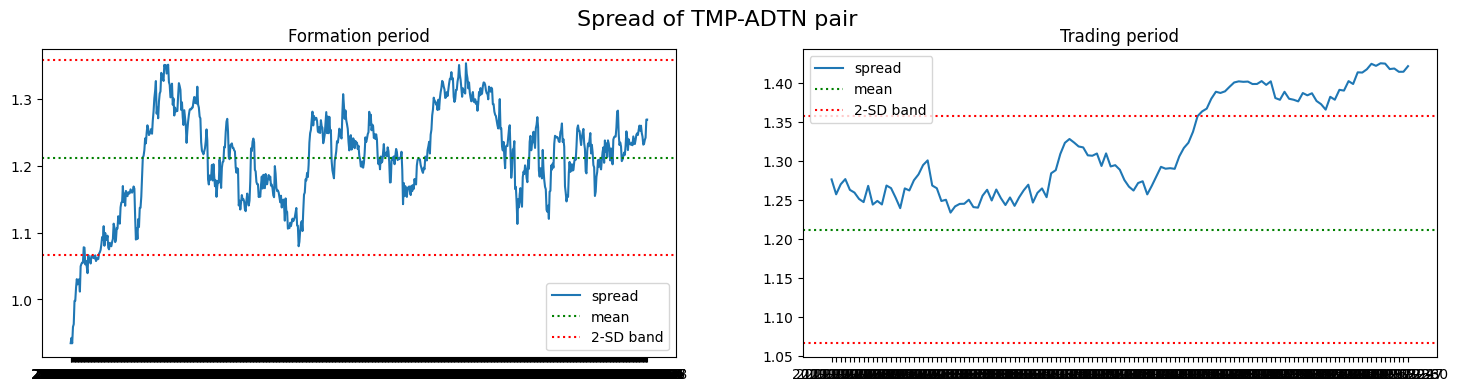

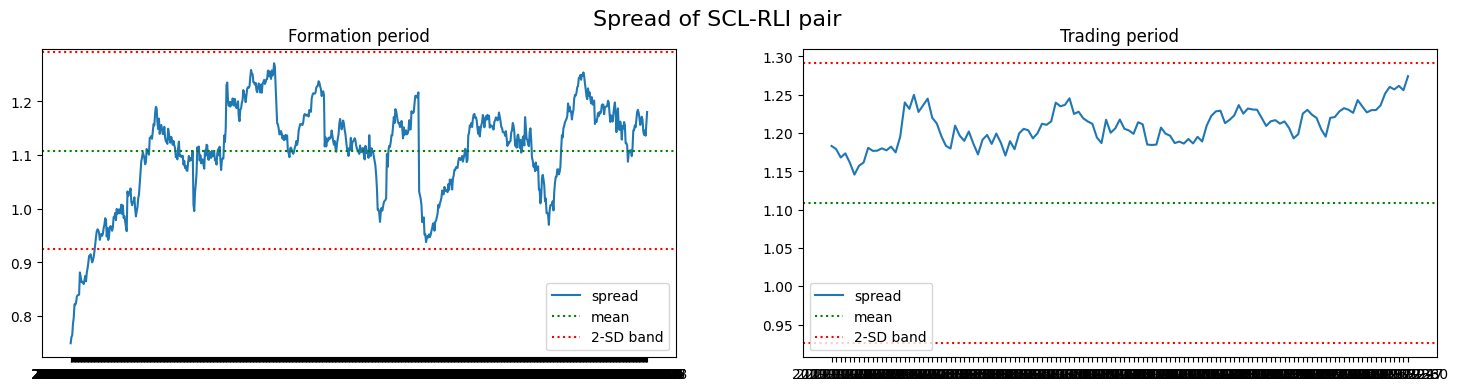

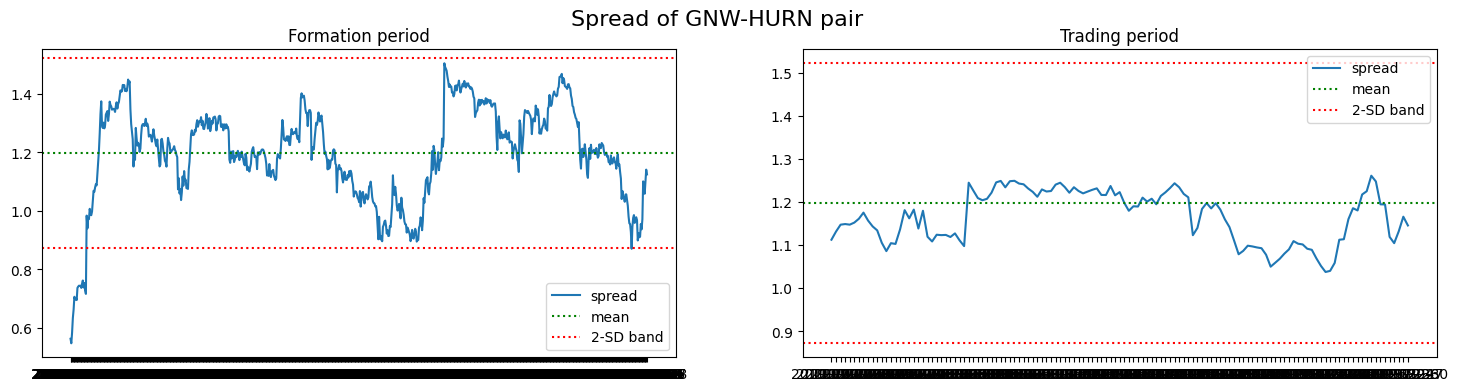

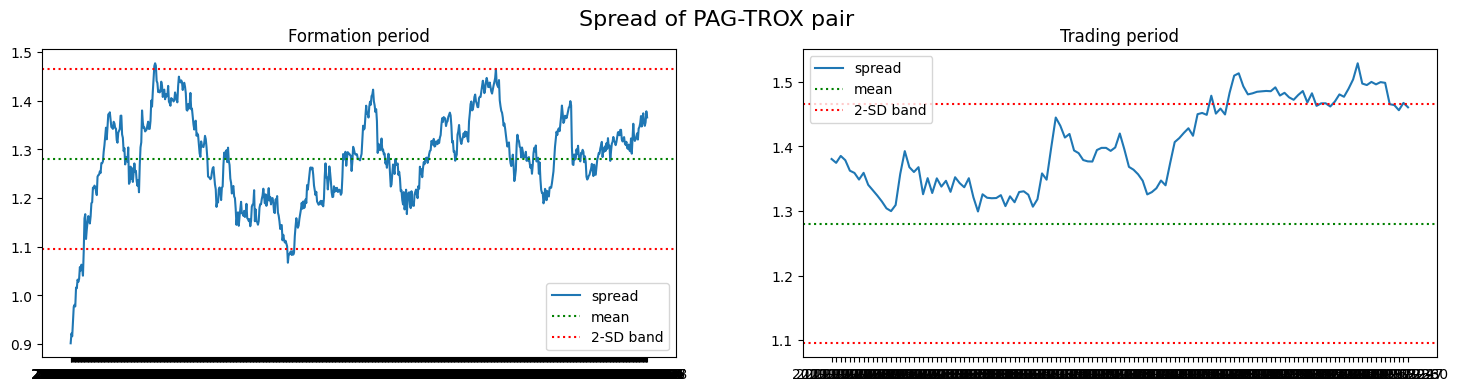

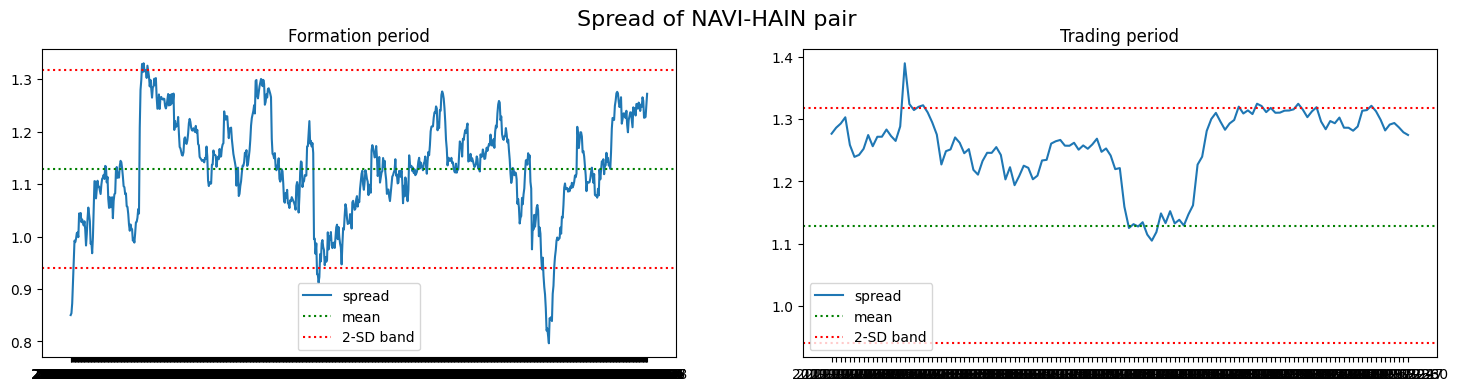

In [89]:
plot_pairs(selected_pairs, test_form, test_trade)